### Multiround UNL Attack 

March 6 2024
TJ Kim

##### Summary
Load FAT model trained for 150 rounds and for 50 rounds try and inject FedAvg model into the system. Try different scaling rates and spread out the model replacement attack.

Copying CIFAR-10 for CELEBA data set -- expect things to go wrong initially due to results in celeba alpha line experiments.

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

In [3]:
setting, num_user, experiment  = "FedAvg", 40, 'cifar100'

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user, experiment)


for client in aggregator.clients:
    client.dataset_name = experiment

# Load models for FAT and FedAvg
save_path_FAT = 'weights/cifar100/240222_FedAvg200round_lr001/FAT/'
save_path_FedAvg = 'weights/cifar100/240222_FedAvg200round_lr001/FedAvg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


 39%|███▉      | 39/100 [00:00<00:00, 342.43it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:09<00:00,  4.31it/s]


In [4]:
# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key]

In [5]:
# Find mag norm 
mag_norm_FAT2FedAvg = []
for key in desired_keys: #params_FAT:

    diff =  params_FAT[key] - params_FedAvg[key]
    l2_norm = torch.norm(diff, p=2)

    mag_norm_FAT2FedAvg += [diff/torch.norm(diff,p=2)]


In [6]:
beta_params = [0.2]
num_aru = [5]
weight2_list = [0.05]
num_rounds = 30


result_list = []
for itt in range(len(beta_params)):
    result_list += [{}]

setting, num_user, experiment = "FedAvg_adv", 40, "cifar100"
save_path_FedAvg_150R = save_path_FAT
aggregator, clients, args_ = set_args(setting, num_user, experiment)
aggregator.aggregation_op = 'trimmed_mean'

if True:
    print("updating adv data set")
    # add adv dataset update
    Fu = np.zeros(num_user)
    Fu[0:10] = 1

    # Setting evasion attack parameters
    x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
    x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = 10,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)

    # Assign proportion and attack params
    for c in range(len(clients)):
        if Fu[c] > 0:
            aggregator.clients[c].set_adv_params(Fu[c], atk_params)
            aggregator.clients[c].update_advnn()
            aggregator.clients[c].assign_advdataset()

for itt in range(len(beta_params)):
    # Perform 50 rounds of FAT on FedAvg model 
    num_adv = num_aru[itt]
    weight2 = 1/num_adv * weight2_list[itt]
    adv_id = random.sample(range(10,num_user), num_adv) # excluding 0-9 as Fu = 1
    beta = beta_params[itt]

    test_acc_gather = []
    adv_acc_gather = []
    test_acc_std = []
    adv_acc_std = []
    cosine_gather_layers = np.zeros([num_rounds, len(desired_keys)])

    aggregator.tm_rate = beta

    # Test performance of aggregator on data 
    aggregator.load_state(dir_path = save_path_FedAvg_150R)
    aggregator.update_clients()
    model_FA = pull_model_from_agg(aggregator)
    model_FA.eval()
    acc, adv_acc = get_adv_acc(aggregator, model_FA)

    prev_model = copy.deepcopy(model_FA)

    print("Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
    test_acc_gather+= [np.mean(acc)]
    adv_acc_gather += [np.mean(adv_acc)]
    test_acc_std += [np.std(acc)]
    adv_acc_std += [np.std(adv_acc)]



    for i in range(num_rounds):

        # Per round Freq

        # aggregator.mix()
        UNL_mix(aggregator, adv_id, model_inject = model_Fedavg, keys = desired_keys, weight_scale_2 = weight2, dump_flag=False, tm_beta=beta)
        model_overfit = pull_model_from_agg(aggregator)
        model_overfit.eval()
        acc, adv_acc = get_adv_acc(aggregator, model_overfit)

        print("round", i,"Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
        test_acc_gather+= [np.mean(acc)]
        adv_acc_gather += [np.mean(adv_acc)]
        test_acc_std += [np.std(acc)]
        adv_acc_std += [np.std(adv_acc)]
        prev_model = copy.deepcopy(model_overfit)

        result_list[itt]['test_acc'] = copy.deepcopy(test_acc_gather)
        result_list[itt]['adv_acc'] = copy.deepcopy(adv_acc_gather)
        result_list[itt]['test_std'] = copy.deepcopy(test_acc_std)
        result_list[itt]['adv_std'] = copy.deepcopy(adv_acc_std)
        result_list[itt]['num_clients'] = num_adv
        result_list[itt]['beta'] = beta
        result_list[itt]['weight2'] = weight2_list[itt]
        # Perform gradient direction gathering

    

==> Clients initialization..
===> Building data iterators..


 39%|███▉      | 39/100 [00:00<00:00, 313.59it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:12<00:00,  3.20it/s]


updating adv data set
Test acc:  0.411458358168602 adv acc:  0.08416667128913105
round 0 Test acc:  0.4168750196695328 adv acc:  0.08083333747927099
round 1 Test acc:  0.41395835727453234 adv acc:  0.07312500369735062
round 2 Test acc:  0.4135416880249977 adv acc:  0.06604166978504508
round 3 Test acc:  0.4135416872799397 adv acc:  0.06041666988749057
round 4 Test acc:  0.4145833574235439 adv acc:  0.056666669948026535
round 5 Test acc:  0.41687502190470693 adv acc:  0.055625003133900466
round 6 Test acc:  0.4150000222027302 adv acc:  0.05958333667367697
round 7 Test acc:  0.41395835429430006 adv acc:  0.05958333676680923
round 8 Test acc:  0.4127083532512188 adv acc:  0.05958333674352616
round 9 Test acc:  0.41312502324581146 adv acc:  0.05895833692047745
round 10 Test acc:  0.41375002190470694 adv acc:  0.05541666990611702
round 11 Test acc:  0.412708356231451 adv acc:  0.05666667043697089
round 12 Test acc:  0.414791689068079 adv acc:  0.054791670036502184
round 13 Test acc:  0.4147

In [7]:
import pickle

a = result_list

with open('saved_results/tmsweep/cifar100/tm_test.pk', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# load relevant information and plot 
plot_settings = [[5, 0.2, 0.05]]

adv_acc_plotter = []
adv_std_plotter = []

# LINE NO 1
with open('saved_results/tmsweep/cifar100/tm_test.pk', 'rb') as handle:
    loaded = pickle.load(handle)
adv_acc_plotter += [loaded[0]["adv_acc"]]
adv_std_plotter += [loaded[0]["adv_std"]]



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


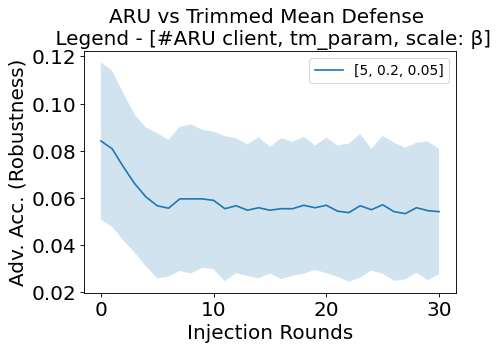

In [9]:
import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6,4))

# Generate some sample data
x = range(len(adv_acc_plotter[0]))  # 100 points from 0 to 10

# Plotting the lines
# plt.plot(x, y1, label='Test Acc')
label_list = plot_settings
for i in range(len(label_list)):
    y = np.array(adv_acc_plotter[i])
    error = np.array(adv_std_plotter[i])
    plt.plot(x, y, label= str(label_list[i]))
    plt.fill_between(x, y-error, y+error,
    alpha=0.2)

# Adding labels and title
plt.xlabel('Injection Rounds')
plt.ylabel('Adv. Acc. (Robustness)')
plt.title('ARU vs Trimmed Mean Defense \n Legend - [#ARU client, tm_param, scale: β]', fontsize = 'medium')

# Adding a legend
plt.legend( loc=1, fontsize='x-small')

# Display the plot
plt.show()


In [10]:
loaded[0]["adv_std"]

[0.03342695367408653,
 0.03313482760826842,
 0.03120761112493294,
 0.02924914015313411,
 0.0294480490175457,
 0.030799533136291093,
 0.029010745246278485,
 0.030593097161605066,
 0.031598063112551915,
 0.02925878499115747,
 0.0291897246209446,
 0.030762872102790783,
 0.02857738259010815,
 0.027943863210414376,
 0.02994207526373033,
 0.02686692515178314,
 0.029904363079524994,
 0.028415935615227726,
 0.02904065170421146,
 0.026431253696189837,
 0.028740186484742275,
 0.027825568294897556,
 0.029341737776016768,
 0.030459446441157365,
 0.025873625585216865,
 0.02925878443047594,
 0.029344696051928833,
 0.027938425983621472,
 0.027588243762806657,
 0.02945983771595869,
 0.02661453418200713]